# Diabetes Prediction using R

## Get the Data

### Loading the required libraries

In [1]:
library(mlbench)
library(ggplot2)
library(dplyr)
library(GGally)
library(knitr)
library(e1071)
library(caTools)
library(ROCR)
library(caret)
library(lattice)
library(rpart)
library(rpart.plot)
library(tree)
library(heatmaply)
library(factoextra)
library(rattle)
library(DT)
library(rmarkdown)
library(xtable)
library(IRdisplay)
library(repr)

Warning message:
"package 'mlbench' was built under R version 3.6.3"
Warning message:
"package 'dplyr' was built under R version 3.6.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Warning message:
"package 'e1071' was built under R version 3.6.3"
Warning message:
"package 'caTools' was built under R version 3.6.3"
Warning message:
"package 'ROCR' was built under R version 3.6.3"
Loading required package: lattice

Warning message:
"package 'rpart.plot' was built under R version 3.6.3"
Warning message:
"package 'tree' was built under R version 3.6.3"
Warning message:
"package 'heatmaply' was built under R version 3.6.3"
Loading required package: plotly

Warning message:
"package 'plotly' was built under R version 4.2.0"

Attaching package: 'plotly'


The

### Loading the dataset

In [2]:
data(PimaIndiansDiabetes)
df = PimaIndiansDiabetes

### Changing the Column Names

In [3]:
colnames(df) = c("Pregnant","Glucose", "Pressure", "Triceps","Insulin", "Mass","Pedigree","Age","Diabetes")
display_html(paste(capture.output(print(head(xtable(df),8), type = 'html')), collapse="", sep=" "))

,Pregnant,Glucose,Pressure,Triceps,Insulin,Mass,Pedigree,Age,Diabetes
1,6.00,148.00,72.00,35.00,0.00,33.60,0.63,50.00,pos
2,1.00,85.00,66.00,29.00,0.00,26.60,0.35,31.00,neg
3,8.00,183.00,64.00,0.00,0.00,23.30,0.67,32.00,pos
4,1.00,89.00,66.00,23.00,94.00,28.10,0.17,21.00,neg
5,0.00,137.00,40.00,35.00,168.00,43.10,2.29,33.00,pos
6,5.00,116.00,74.00,0.00,0.00,25.60,0.20,30.00,neg
7,3.00,78.00,50.00,32.00,88.00,31.00,0.25,26.00,pos
8,10.00,115.00,0.00,0.00,0.00,35.30,0.13,29.00,neg


## Data Exploration

### Checking the Data Types

In [4]:
str(df)

'data.frame':	768 obs. of  9 variables:
 $ Pregnant: num  6 1 8 1 0 5 3 10 2 8 ...
 $ Glucose : num  148 85 183 89 137 116 78 115 197 125 ...
 $ Pressure: num  72 66 64 66 40 74 50 0 70 96 ...
 $ Triceps : num  35 29 0 23 35 0 32 0 45 0 ...
 $ Insulin : num  0 0 0 94 168 0 88 0 543 0 ...
 $ Mass    : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ Pedigree: num  0.627 0.351 0.672 0.167 2.288 ...
 $ Age     : num  50 31 32 21 33 30 26 29 53 54 ...
 $ Diabetes: Factor w/ 2 levels "neg","pos": 2 1 2 1 2 1 2 1 2 2 ...


We can see that there are 9 different variables 8 of them are numeric while the last one is a categorical variable.

### Checking the missing values count

In [5]:
# Creating a function to determine missing values in each column
nullvalues = function(dataset) {
aa = c()
bb = c()
for (count in 1:length(dataset)) {
  aa <- append(aa,colnames(dataset)[count])
  bb <- append(bb,sum(is.na(dataset[colnames(dataset)[count]])))
}
missing_values=NULL
missing_values$Columns <- aa
missing_values$`Missing Values Count` <- bb
missing_values <- data.frame(missing_values)

display_html(paste(capture.output(print(xtable(missing_values), type = 'html')), collapse="", sep=" "))

}

# Using the function to determine missing values in df
nullvalues(df)

,Columns,Missing.Values.Count
1,Pregnant,0
2,Glucose,0
3,Pressure,0
4,Triceps,0
5,Insulin,0
6,Mass,0
7,Pedigree,0
8,Age,0
9,Diabetes,0


 Clearly none of the columns have missing values.

### Scatter Matrix Plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



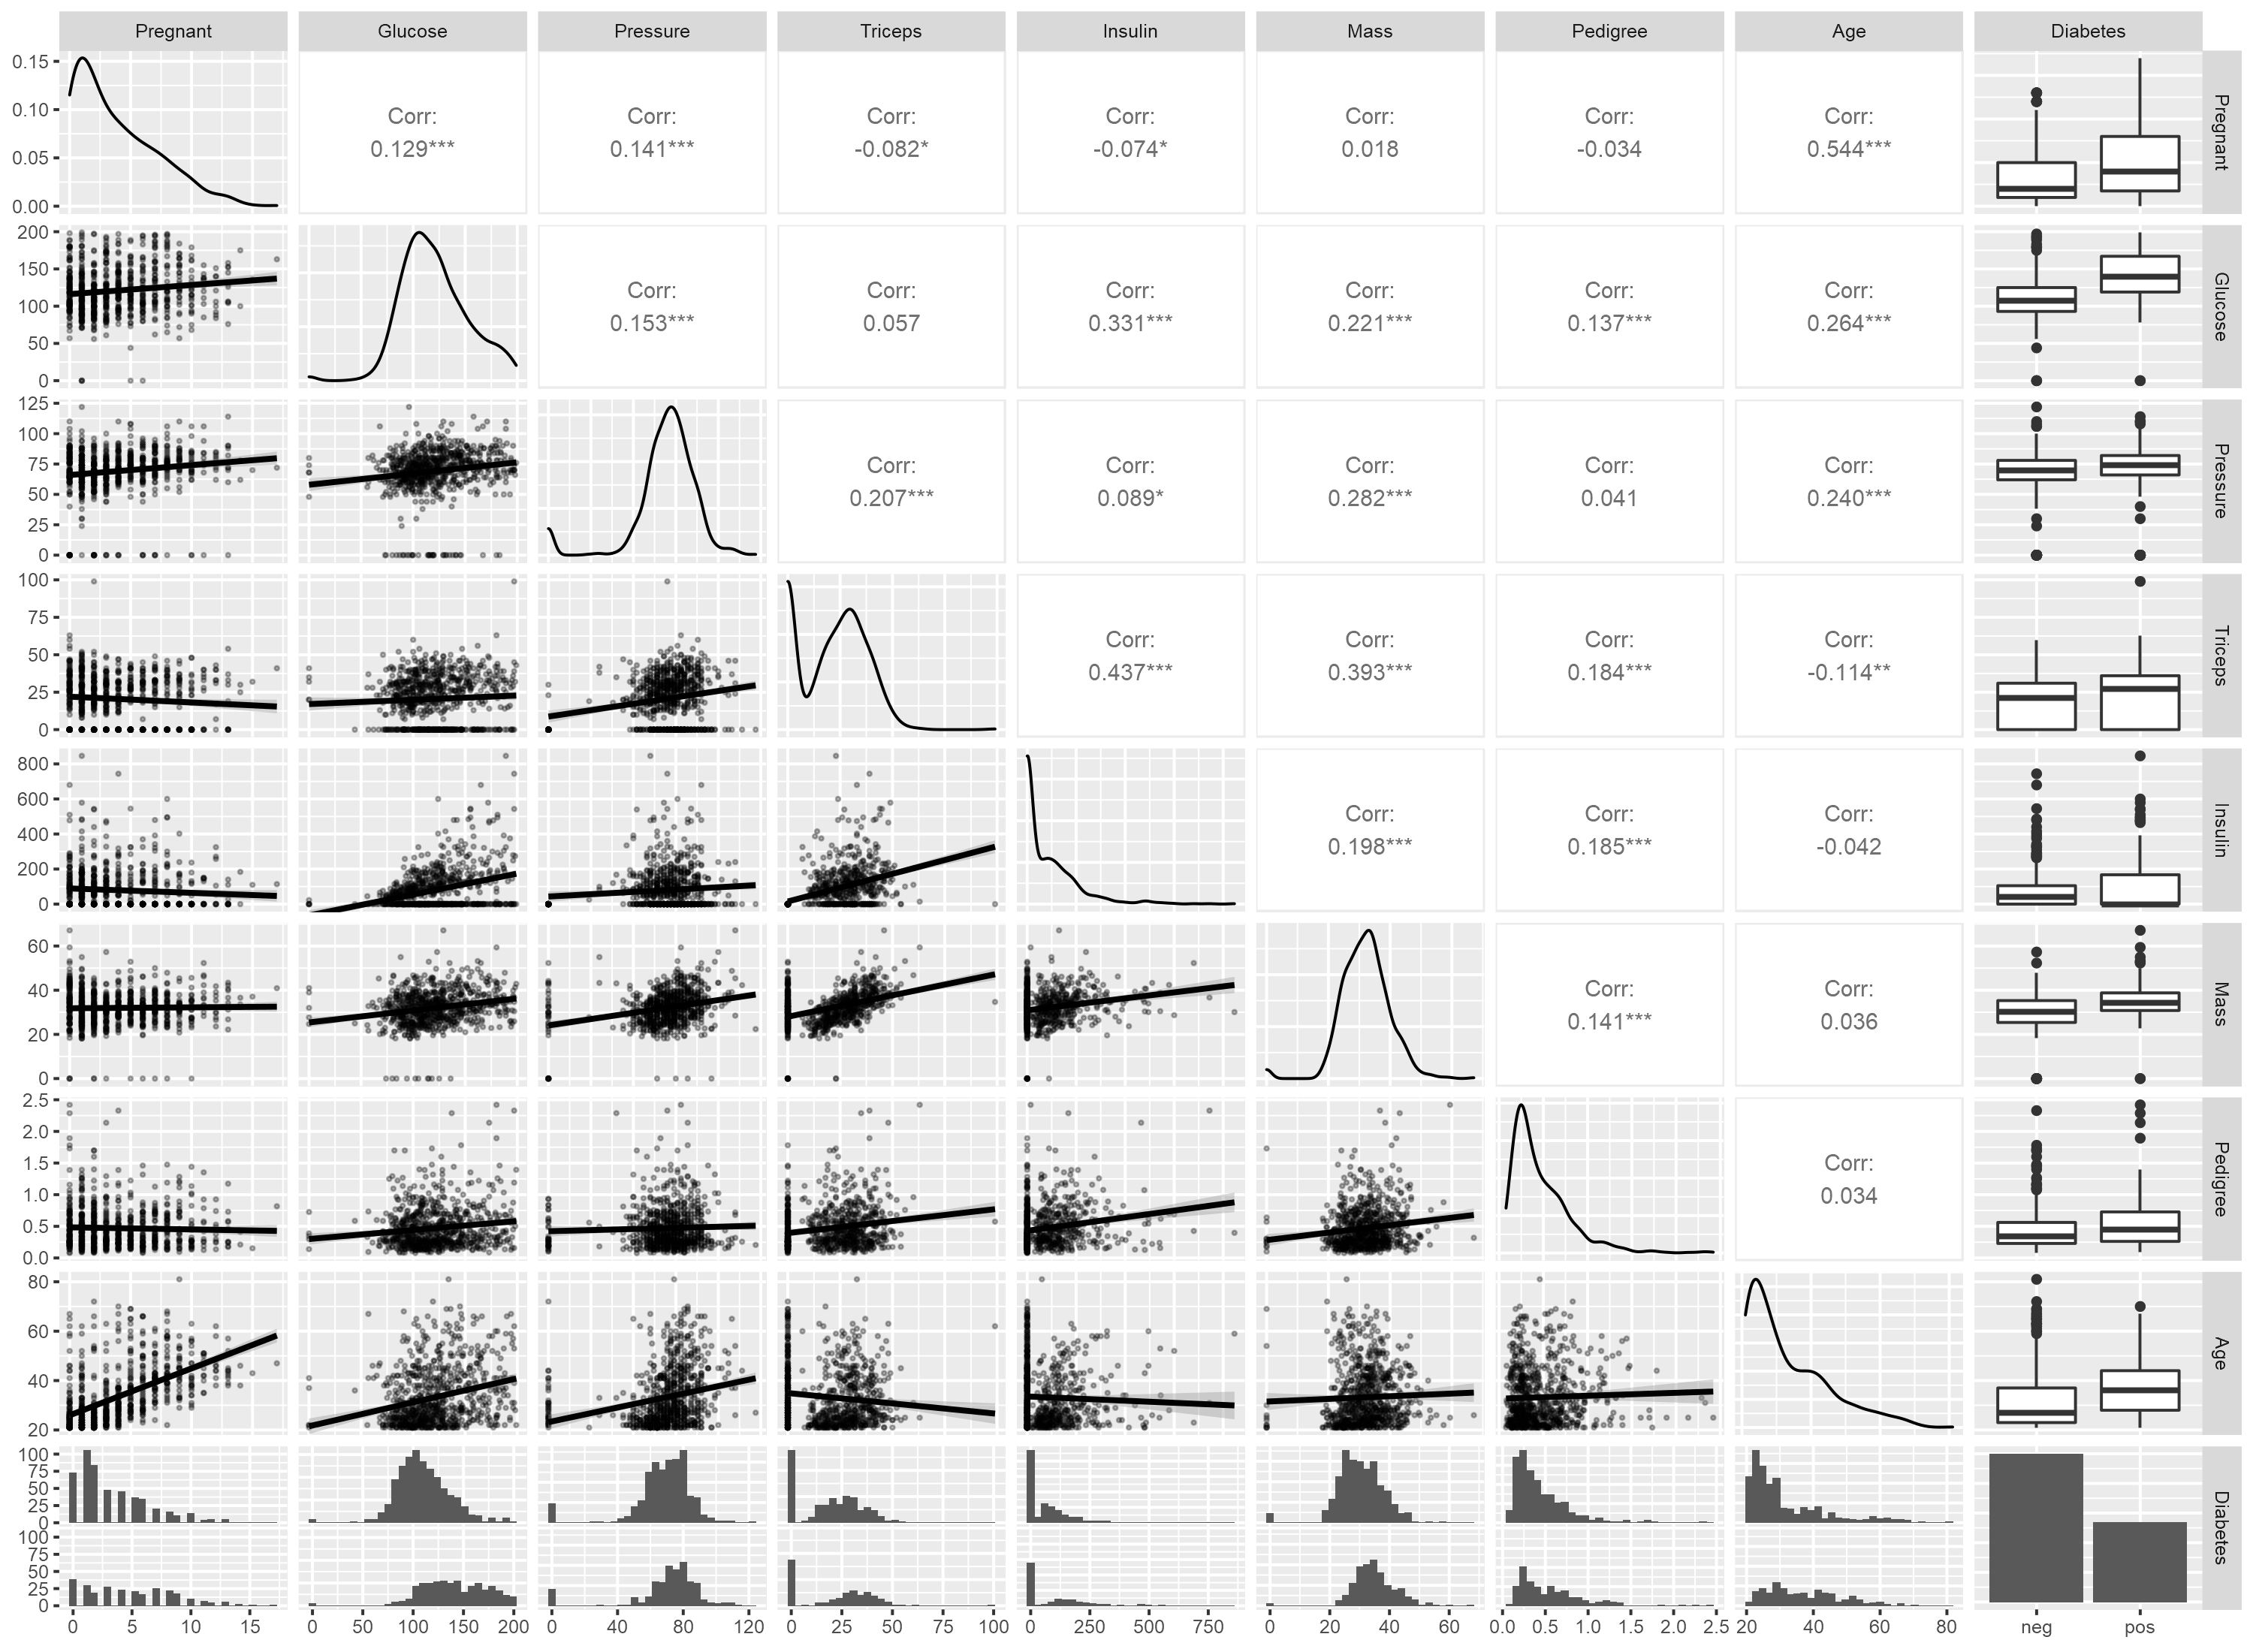

In [6]:
options(repr.plot.width=15, repr.plot.height=11,repr.plot.res = 200)
ggpairs(df, lower = list(continuous = wrap("smooth", alpha = 0.3, size=0.5)))

### Class distribution and skewness

In [7]:
y <- df$Diabetes
xtable((cbind(freq=table(y), percentage=prop.table(table(y))*100)))

,freq,percentage
neg,500,65.10417
pos,268,34.89583


In [8]:
skew_df = data.frame("Column_names" = as.character(), "Skewness" = as.numeric(), stringsAsFactors = F)
for (i1 in 1:8) {
  skew_df[i1,1:2]= rep(1,length(1:8)) 
  skew_df[i1,1] = colnames(df[i1])
  skew_df[i1,2] = skewness(df[,i1])
}
skew_df

Column_names,Skewness
Pregnant,0.8981549
Glucose,0.1730754
Pressure,-1.8364126
Triceps,0.1089456
Insulin,2.2633826
Mass,-0.4273073
Pedigree,1.9124179
Age,1.1251880


## Logistic Regression Model

### Train Test Split

In [9]:
#Splitting the data in train & test
set.seed(123)
split = sample.split(df, SplitRatio = 0.75)
train = subset(df, split=="TRUE")
test = subset(df, split=="FALSE")

### Model Development

In [10]:
#Creating the logistic regression model
logregmodel<-glm(Diabetes ~Pregnant+Glucose+Pedigree+Mass , data = train, family="binomial")
summary(logregmodel)
df_test<-predict(logregmodel, newdata = test, type = "response")


Call:
glm(formula = Diabetes ~ Pregnant + Glucose + Pedigree + Mass, 
    family = "binomial", data = train)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7574  -0.7076  -0.3675   0.6713   2.4909  

Coefficients:
             Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.516192   0.886670 -10.733  < 2e-16 ***
Pregnant     0.188030   0.034722   5.415 6.12e-08 ***
Glucose      0.037514   0.004434   8.461  < 2e-16 ***
Pedigree     1.147900   0.384413   2.986  0.00283 ** 
Mass         0.088841   0.017316   5.130 2.89e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 663.60  on 512  degrees of freedom
Residual deviance: 466.43  on 508  degrees of freedom
AIC: 476.43

Number of Fisher Scoring iterations: 5


In [11]:
#Range of probabilities on the test set
round(range(df_test),5)

[1] 0.00094 0.99499

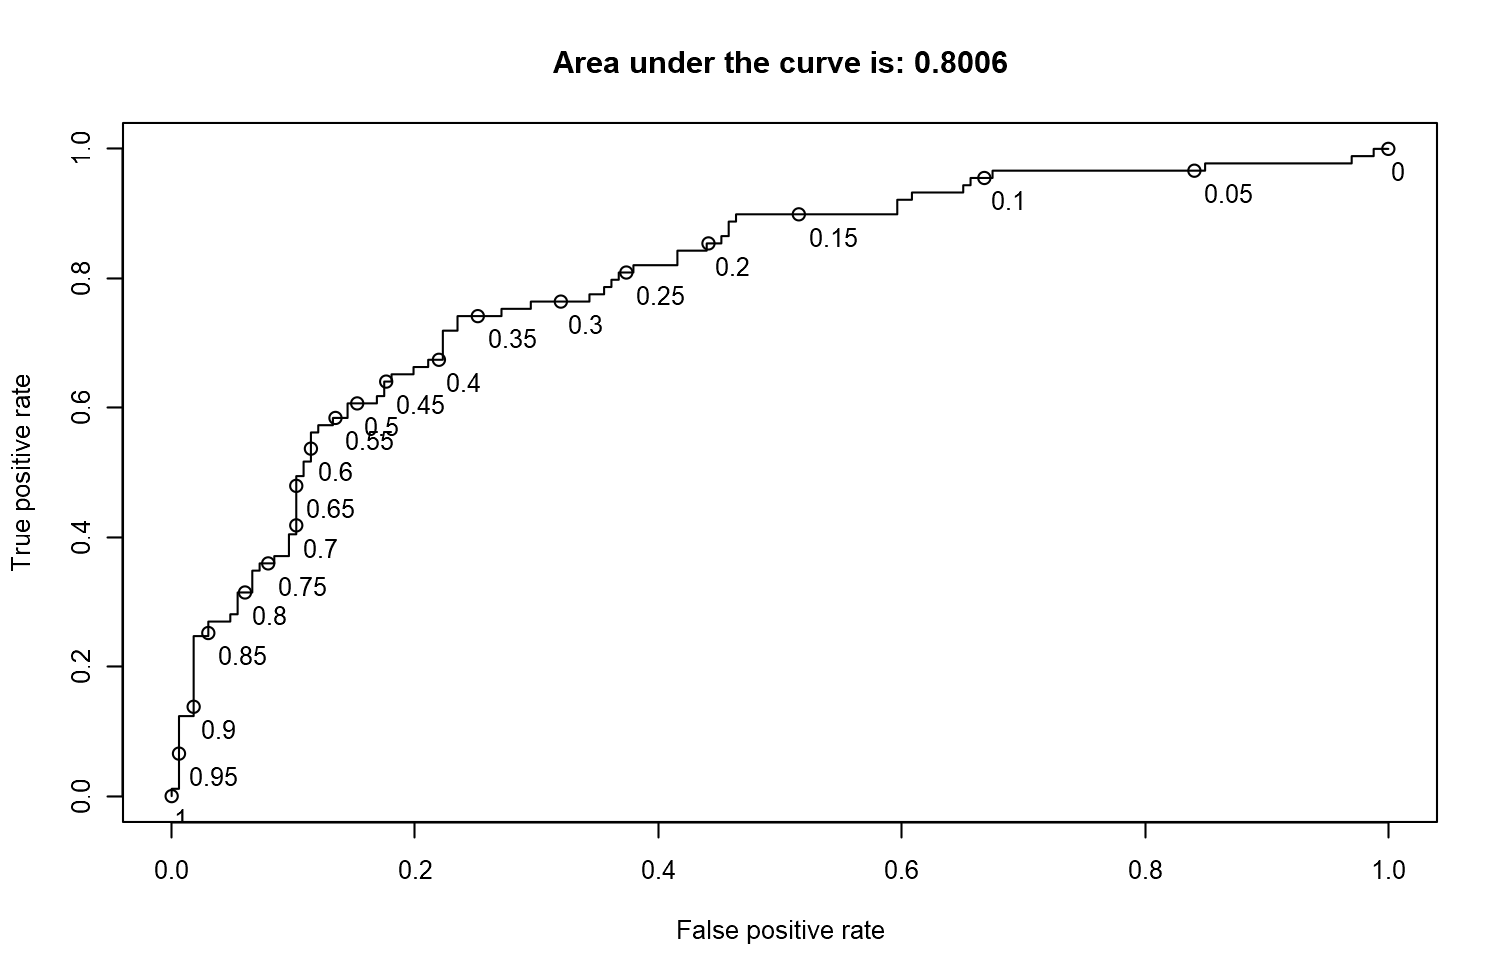

In [28]:
## Plotting the regression model
ROCpred<- prediction(df_test, test$Diabetes) #putting the test data into the classification model
ROCRperf<-performance(ROCpred, "tpr", "fpr") #using tpr and fpr
AUC<-as.numeric(performance(ROCpred, 'auc')@y.values) #Calculating the area under curve

options(repr.plot.height=6.5, repr.plot.res = 150)
plot(ROCRperf, print.cutoffs.at = seq(0,1,0.05), text.adj = c(-0.2, 1.7), 
    main = paste("Area under the curve is:", round(AUC,5))) #plotting the points on the curve

### Model Evaluation

In [36]:
## Setting the threshold & predicting the accuracy of the model
pos_neg = ifelse(df_test>0.3, "pos", "neg")
df_class <- factor(pos_neg, levels = levels(test$Diabetes))
confusionMatrix(table(df_class, test$Diabetes),positive = "pos")

Confusion Matrix and Statistics

        
df_class neg pos
     neg 113  21
     pos  53  68
                                          
               Accuracy : 0.7098          
                 95% CI : (0.6499, 0.7647)
    No Information Rate : 0.651           
    P-Value [Acc > NIR] : 0.0271240       
                                          
                  Kappa : 0.4105          
                                          
 Mcnemar's Test P-Value : 0.0003137       
                                          
            Sensitivity : 0.7640          
            Specificity : 0.6807          
         Pos Pred Value : 0.5620          
         Neg Pred Value : 0.8433          
             Prevalence : 0.3490          
         Detection Rate : 0.2667          
   Detection Prevalence : 0.4745          
      Balanced Accuracy : 0.7224          
                                          
       'Positive' Class : pos             
                                          

## Decision Tree Model

In [14]:
## Decision Tree
set.seed(123)
k = trainControl(method="cv", number=10)
cpvalues = expand.grid(.cp = seq(0.01, 0.2, 0.01)) ## Performing 10 fold cross validation
train(Diabetes ~Pregnant+Glucose+Pedigree+Mass, data =train, 
      method = "rpart", trControl = k, tuneGrid = cpvalues)
dec_tree_df<-rpart(Diabetes ~Pregnant+Glucose+Pedigree+Mass+Pedigree,
                 data = train, method = "class", cp=0.02)

CART 

513 samples
  4 predictor
  2 classes: 'neg', 'pos' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 461, 461, 462, 462, 463, 462, ... 
Resampling results across tuning parameters:

  cp    Accuracy   Kappa    
  0.01  0.7582745  0.4541347
  0.02  0.7699683  0.4790324
  0.03  0.7563183  0.4373234
  0.04  0.7523952  0.4116376
  0.05  0.7523952  0.4116376
  0.06  0.7523952  0.4116376
  0.07  0.7523952  0.4116376
  0.08  0.7523952  0.4116376
  0.09  0.7523952  0.4116376
  0.10  0.7385520  0.3886914
  0.11  0.7307843  0.3750574
  0.12  0.7269005  0.3782024
  0.13  0.7288235  0.3857187
  0.14  0.7288235  0.3857187
  0.15  0.7288235  0.3857187
  0.16  0.7288235  0.3857187
  0.17  0.7288235  0.3857187
  0.18  0.7288235  0.3857187
  0.19  0.7288235  0.3857187
  0.20  0.7288235  0.3857187

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.02.

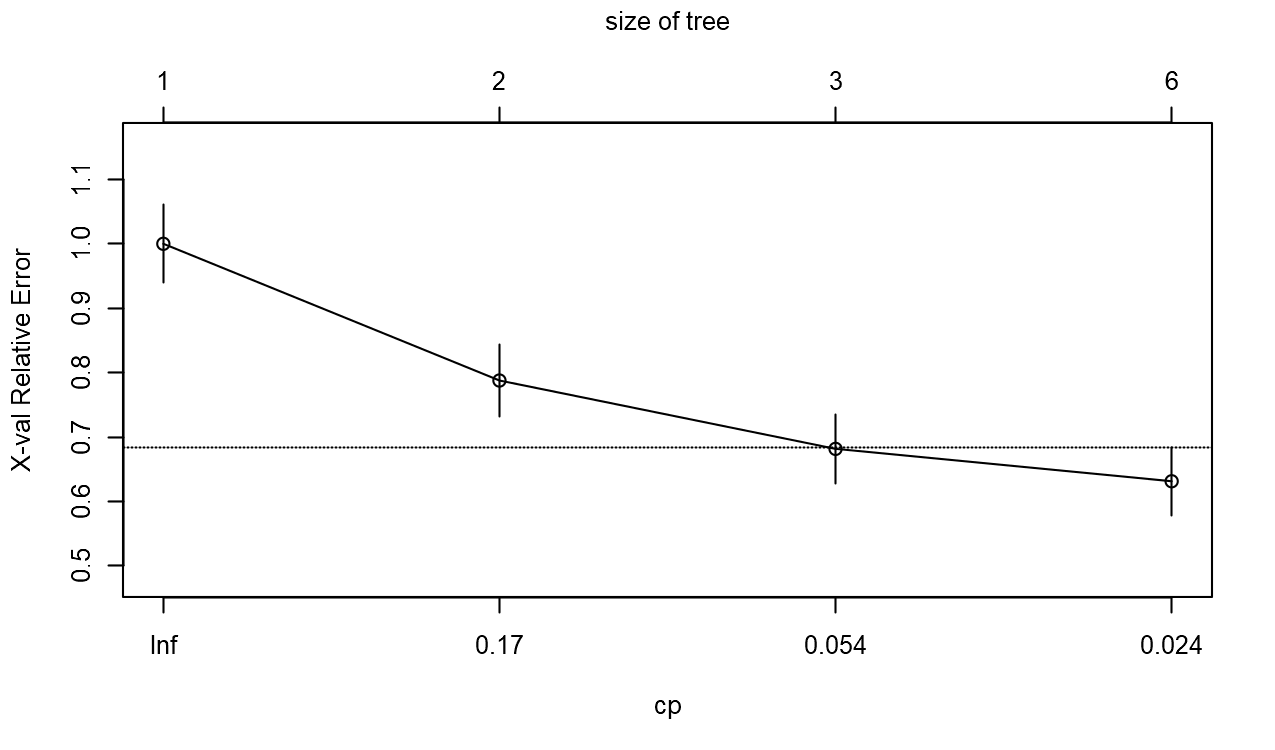

In [15]:
options(repr.plot.width=8.5, repr.plot.height=5)
plotcp(dec_tree_df)

In [16]:
pred<-predict(dec_tree_df, newdata = test, type="class", na.action = na.pass)
head(pred)

4   5   8  13  14  17 
neg pos pos neg pos neg 
Levels: neg pos

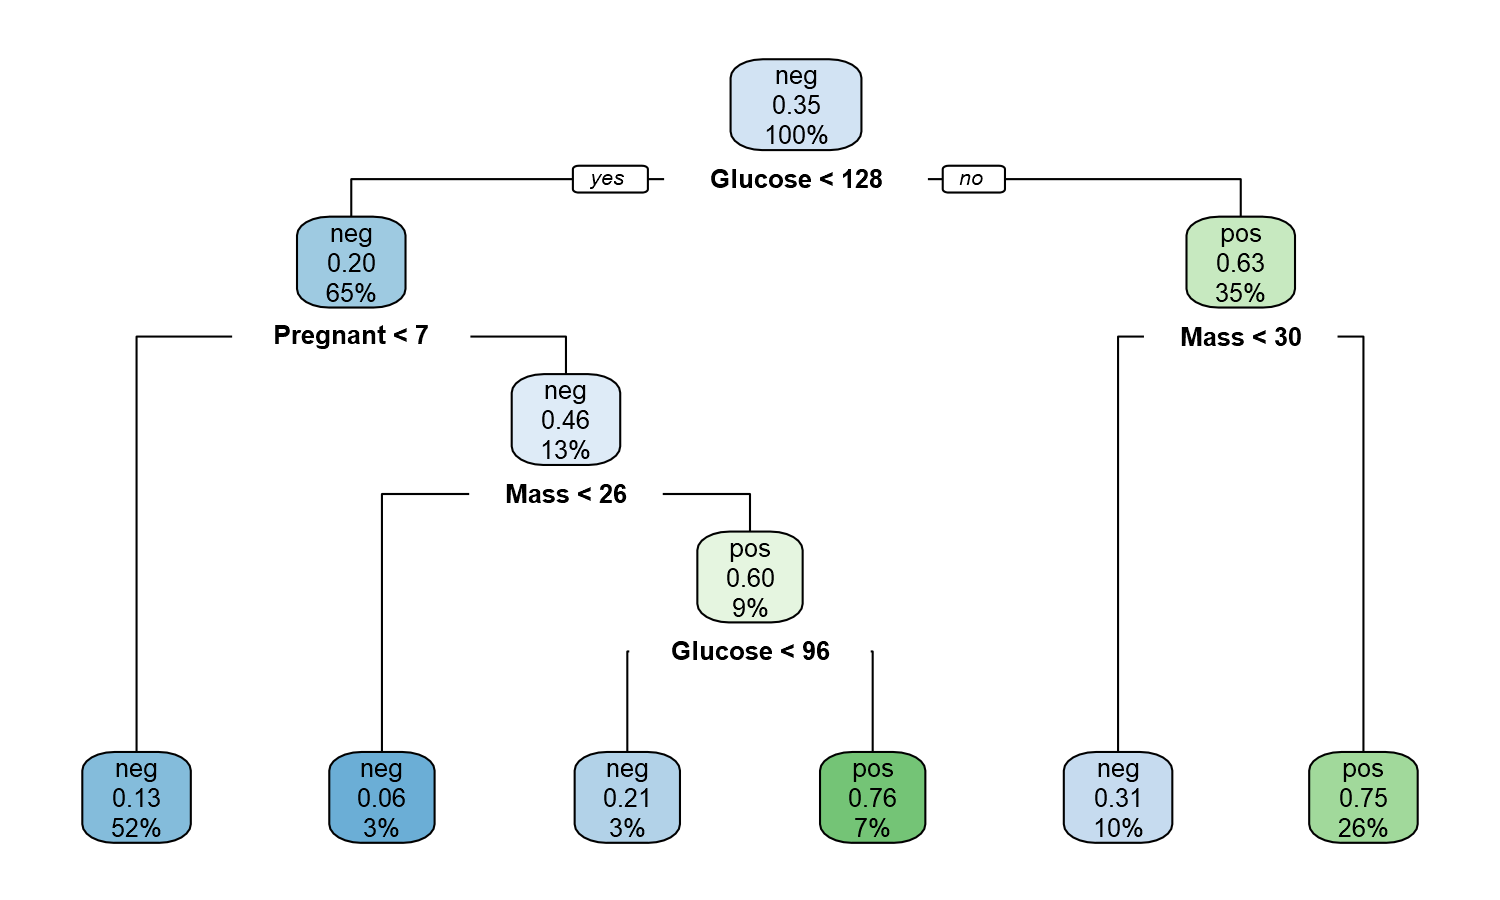

In [39]:
options(repr.plot.height=6, repr.plot.res = 150)
rpart.plot(dec_tree_df)

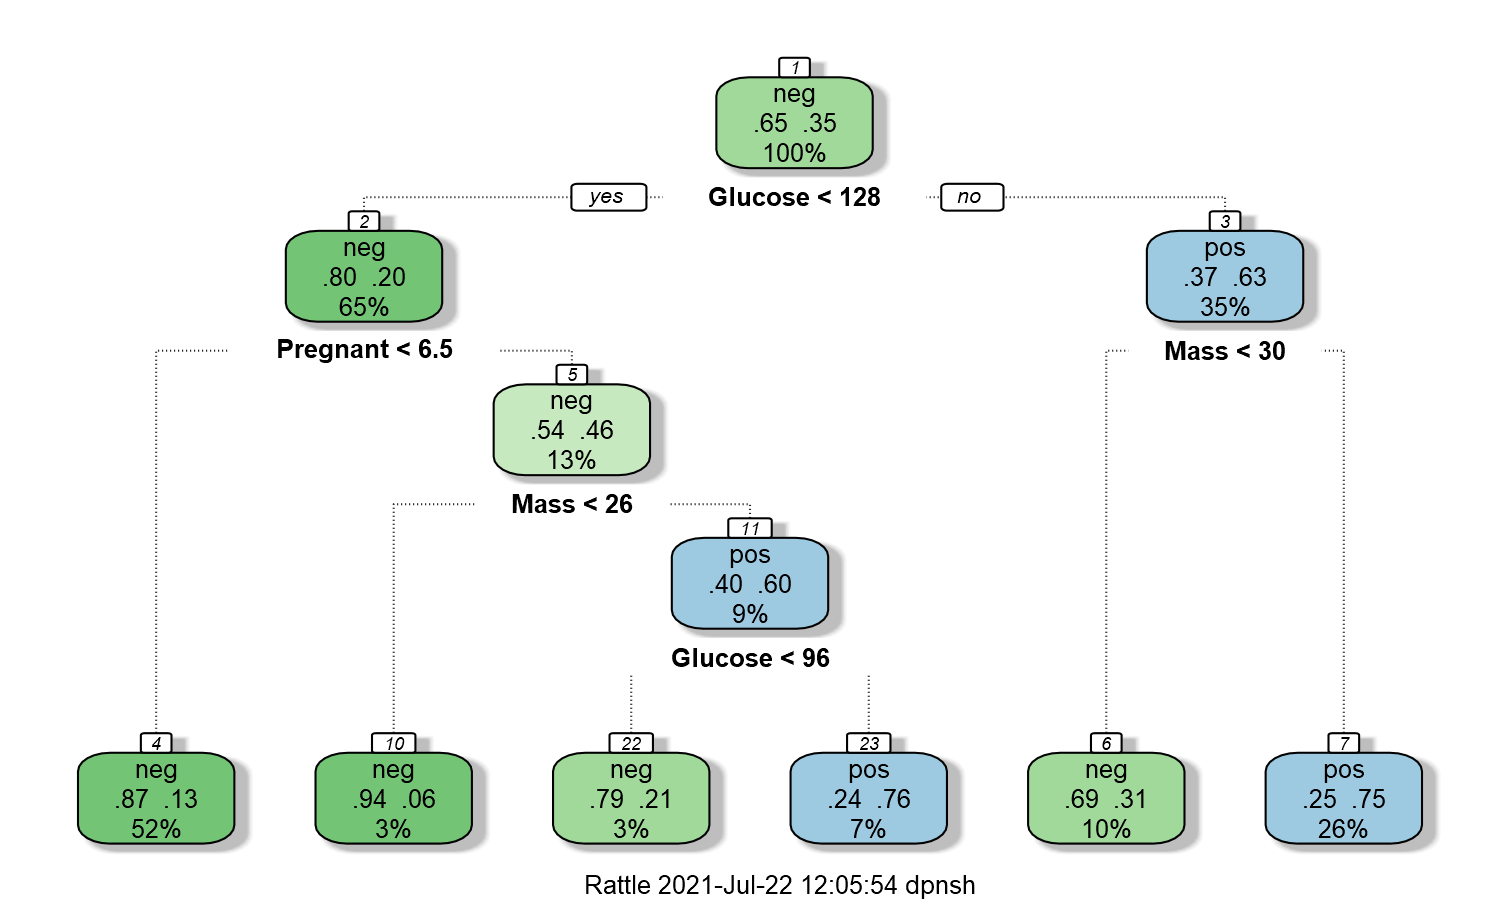

In [40]:
#rattle()
## Plotting the decision tree
#options(repr.plot.width=10, repr.plot.height=8)
options(repr.plot.height=6, repr.plot.res = 150)
fancyRpartPlot(dec_tree_df)

In [34]:
confusionMatrix(table(pred, test$Diabetes),positive = "pos") ## Analyzing the model

Confusion Matrix and Statistics

     
pred  neg pos
  neg 131  34
  pos  35  55
                                          
               Accuracy : 0.7294          
                 95% CI : (0.6705, 0.7829)
    No Information Rate : 0.651           
    P-Value [Acc > NIR] : 0.004584        
                                          
                  Kappa : 0.4061          
                                          
 Mcnemar's Test P-Value : 1.000000        
                                          
            Sensitivity : 0.6180          
            Specificity : 0.7892          
         Pos Pred Value : 0.6111          
         Neg Pred Value : 0.7939          
             Prevalence : 0.3490          
         Detection Rate : 0.2157          
   Detection Prevalence : 0.3529          
      Balanced Accuracy : 0.7036          
                                          
       'Positive' Class : pos             
                                          

In [20]:
## K means 
df_kmeans = df
df_normalize<-normalize(df[-c(9)]) ## Normalizing the data
df_clusters<-kmeans(df_normalize,centers=3,iter.max = 15, nstart = 10)
df_normalize$Cluster_no = df_clusters$cluster
df_sort = df_normalize %>% arrange(Cluster_no)

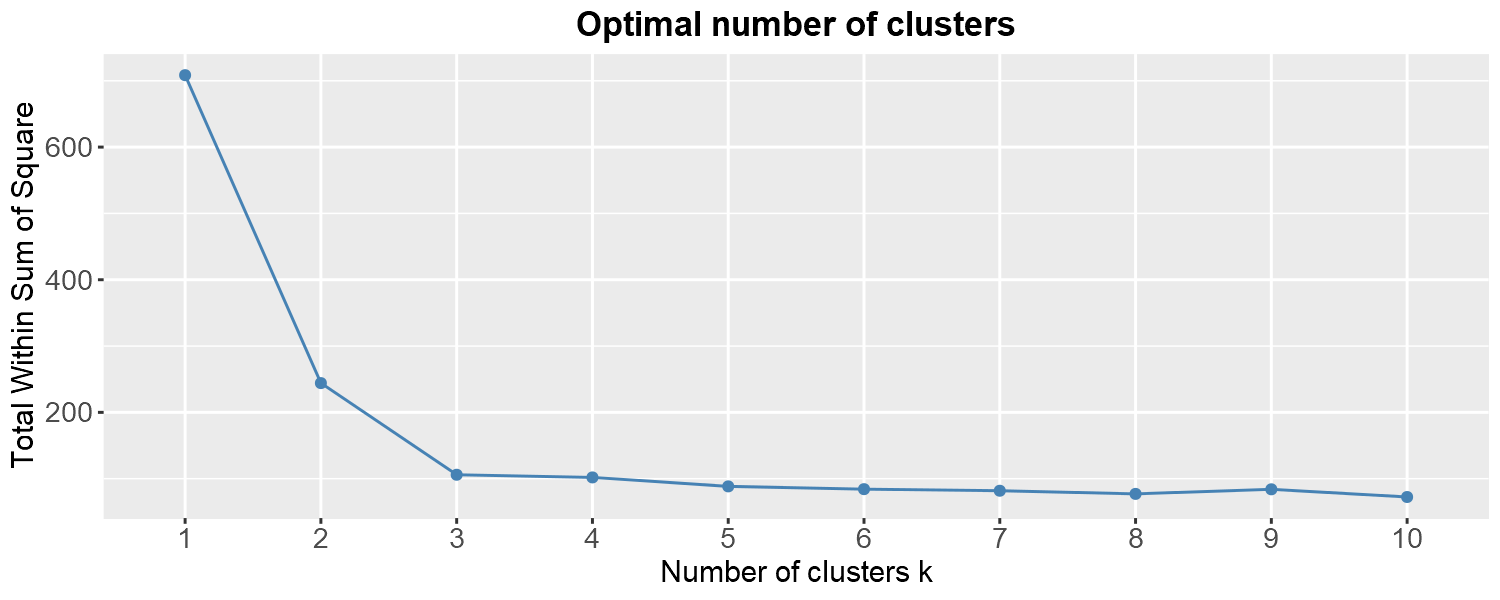

In [21]:
options(repr.plot.width=10, repr.plot.height=4,repr.plot.res = 150)
fviz_nbclust(df_normalize, kmeans, method = "wss") + theme_gray()+theme(axis.title = element_text(size = 14), 
    axis.text = element_text(size = 13), 
    plot.title = element_text(size = 16, 
        face = "bold", hjust = 0.5))

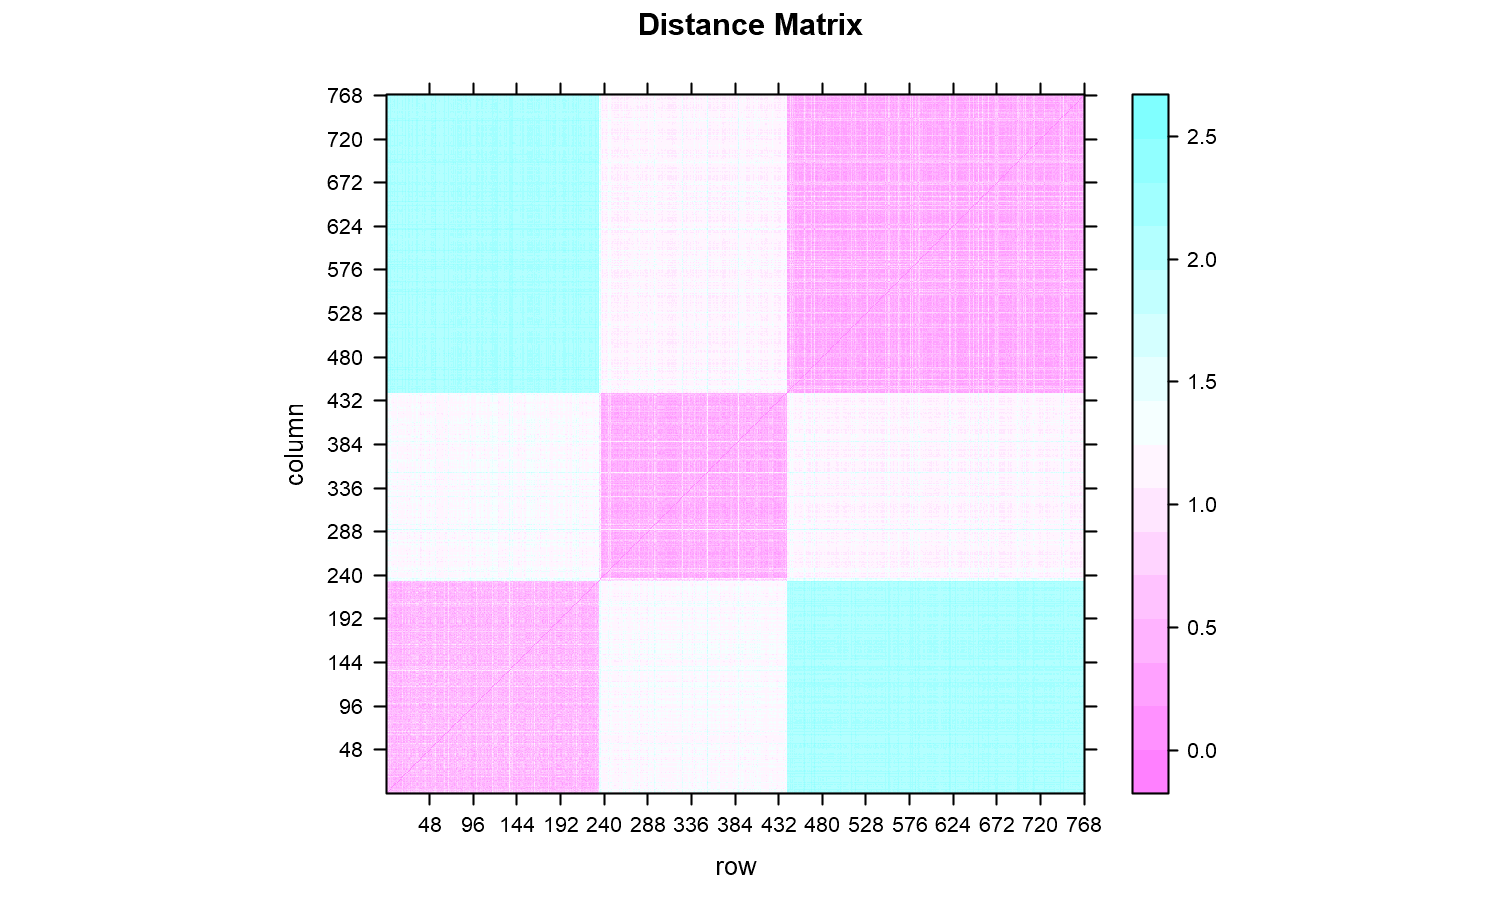

In [25]:
options(repr.plot.res = 150)
DistMatrixSort =  as.matrix(dist(df_sort, method="euclidean"))
x.scale <- list(at=seq(0,768,48))
y.scale <- list(at=seq(0,768,48))
levelplot(DistMatrixSort, scales=list(x=x.scale, y=y.scale), main="Distance Matrix")

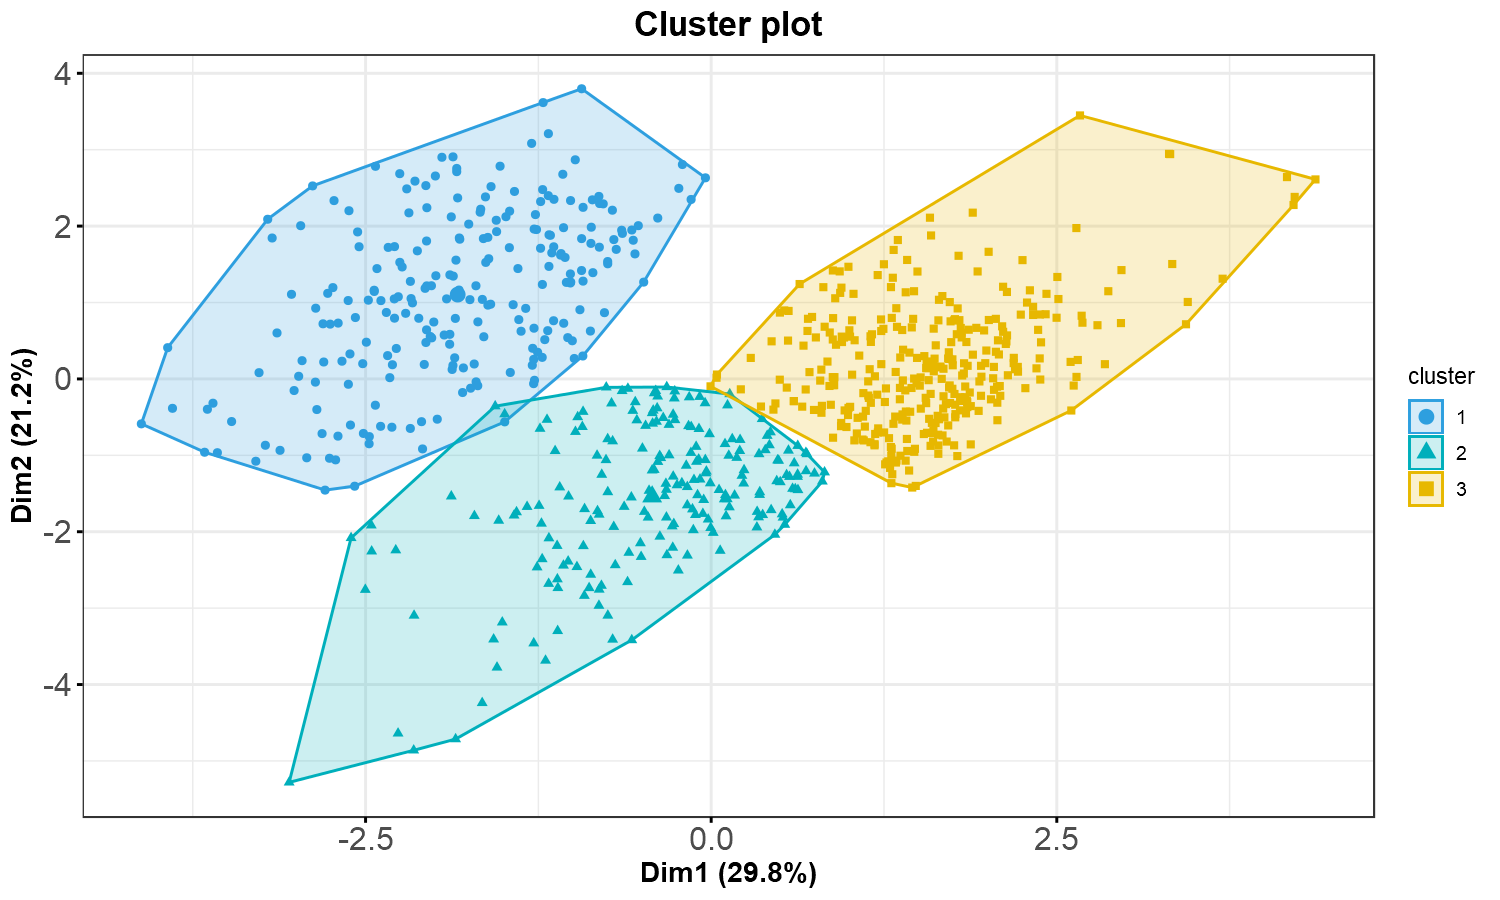

In [26]:
fviz_cluster(df_clusters, data = df_normalize,
             palette = c("#2E9FDF", "#00AFBB", "#E7B800"), 
             geom = "point",
             ellipse.type = "convex", 
             ggtheme = theme_bw()
) + theme(axis.title = element_text(size = 13, 
    face = "bold"), axis.text = element_text(size = 15), 
    plot.title = element_text(size = 16, 
        face = "bold", hjust = 0.5), panel.background = element_rect(fill = NA))